# PyTorch - homework TF 3: generative convolutional models

-- Prof. Dorien Herremans

Please run the whole notebook with your code and submit the `.ipynb` file on eDimension that includes your answers [so after you run it]. 

In [2]:
from termcolor import colored

student_number="1002819"
student_name="Samson Yu Bai Jian"

print(colored("Homework by "  + student_name + ', number: ' + student_number,'red'))

Homework by Samson Yu Bai Jian, number: 1002819


 ## Question 1 -- Generate images based on a condition

Task: develop a generative model (either cGAN or cVaE) that can generate images based on a class label (bee or ant). 

a) Training dataset: small subset of ImageNet: https://download.pytorch.org/tutorial/hymenoptera_data.zip. You can leverage the ImageFolder class as demonstrated here: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html. Since we don't need a test set for generation, you can combine both test and training datasets. 

To handle using custom datasets, torchvision provides a datasets.ImageFolder class. ImageFolder expects data to be stored in the following way:

*   root/class_x/xxy.png
*   root/class_x/xxz.jpg
*   root/class_y/123.jpeg
*   root/class_y/nsdf3.png
*   root/class_y/asd932_.jpg

b) Normalize the training data and perform data augmentation. For those interested in knowing how to calculate the means for normalizing, please refer to this excellent resource here: https://github.com/bentrevett/pytorch-image-classification/blob/master/5%20-%20ResNet.ipynb and the previously mentioned link. 



In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

# %cd 'drive/My Drive'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive


In [16]:
# load images and normalize + augment data
import torchvision
%matplotlib inline
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets, models
import numpy as np
import matplotlib.pyplot as plt

# TODO: Change to your data path
data_dir = './data/hymenoptera_data'

train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), 
                                  transform = transforms.ToTensor())
val_data = datasets.ImageFolder(os.path.join(data_dir, 'val'), 
                                  transform = transforms.ToTensor())
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
])

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms)
                  for x in ['train', 'val']}
batch_size = 8
# combine test and training datasets
dataloader = torch.utils.data.DataLoader(torch.utils.data.ConcatDataset([image_datasets['train'], image_datasets['val']]), batch_size=batch_size,
                                             shuffle=True, num_workers=4)
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


c) Show a few images from the dataset so we understand what we are working with. 



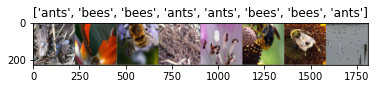

In [17]:
# explore the data
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(means)
    std = np.array(stds)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


d) Implement a conditional generative model. Use at least one convolutional layer in your generative model and define a loss function that makes sense for this problem. 


In [23]:
# your model here
capacity = 64
latent_dims = 100
variational_beta = 1

class Encoder(nn.Module):
    def __init__(self, num_classes, img_size):
        super(Encoder, self).__init__()
        c = capacity
        self.class_emb = nn.Linear(num_classes, img_size * img_size)
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 112 x 112
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: 2c x 56 x 56
        self.fc_mu = nn.Linear(in_features=c*2*56*56, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*56*56, out_features=latent_dims)
            
    def forward(self, x, class_vector, img_size):
        class_emb = self.class_emb(class_vector)
        class_emb = class_emb.view(class_emb.size(0), 1, img_size, img_size)
        x = torch.cat([x, class_emb], 1) # add conditioning
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        # notice, here we use use x for mu and for variance! 
        x_mu = self.fc_mu(x) 
        x_logvar = self.fc_logvar(x) #we don't calculate this from x_mu but from x!! This is crutial. 
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self, num_classes):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims + num_classes, out_features=c*2*56*56)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=3, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x, class_vector):
        x = torch.cat([x, class_vector], 1) # add conditioning
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 56, 56) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = self.conv1(x) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x

class VariationalAutoencoder(nn.Module):
    def __init__(self, num_classes, img_size):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(num_classes, img_size)
        self.decoder = Decoder(num_classes)
    
    def forward(self, x, c, img_size):
        # remember our encoder output consists of x_mu and x_logvar
        latent_mu, latent_logvar = self.encoder(x, c, img_size)
        # we sample from the distributions defined by mu and logvar
        # (function latent_sample defined below)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent, c)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_() #define normal distribution
            return eps.mul(std).add_(mu) #sample from normal distribution
        else:
            return mu

def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.
    recon_loss = F.mse_loss(recon_x.view(-1, 3*224*224), x.view(-1, 3*224*224), reduction='sum')
    
    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + variational_beta * kldivergence


e) Train the network on cuda (I recommend to be clever and use a technique such as mini batches to train effectively, optional though). Show how the loss of the model evolves during training. 

f) Generate 4 images of each class after a number of epochs so we can see the generation quality improving during training.





Training ...
Epoch [1 / 150] average reconstruction error: 1775130.125000
Epoch [2 / 150] average reconstruction error: 1462798.289375
Epoch [3 / 150] average reconstruction error: 1046376.787500
Epoch [4 / 150] average reconstruction error: 924712.513125
Epoch [5 / 150] average reconstruction error: 846625.960625
Epoch [6 / 150] average reconstruction error: 794938.248750
Epoch [7 / 150] average reconstruction error: 752743.841250
Epoch [8 / 150] average reconstruction error: 734141.815000
Epoch [9 / 150] average reconstruction error: 715784.178125


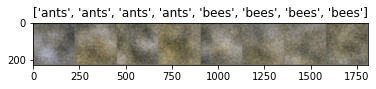

Epoch [10 / 150] average reconstruction error: 701965.329375
Epoch [11 / 150] average reconstruction error: 649427.433125
Epoch [12 / 150] average reconstruction error: 648165.849375
Epoch [13 / 150] average reconstruction error: 629304.146875
Epoch [14 / 150] average reconstruction error: 613971.000625
Epoch [15 / 150] average reconstruction error: 623383.410000
Epoch [16 / 150] average reconstruction error: 601611.317500
Epoch [17 / 150] average reconstruction error: 588798.525000
Epoch [18 / 150] average reconstruction error: 583927.573125
Epoch [19 / 150] average reconstruction error: 574749.376875


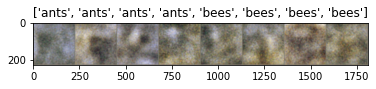

Epoch [20 / 150] average reconstruction error: 550836.345000
Epoch [21 / 150] average reconstruction error: 535253.740000
Epoch [22 / 150] average reconstruction error: 529688.513750
Epoch [23 / 150] average reconstruction error: 501675.493125
Epoch [24 / 150] average reconstruction error: 503717.272500
Epoch [25 / 150] average reconstruction error: 495656.756250
Epoch [26 / 150] average reconstruction error: 490277.875000
Epoch [27 / 150] average reconstruction error: 474203.440000
Epoch [28 / 150] average reconstruction error: 481905.548750
Epoch [29 / 150] average reconstruction error: 466416.440625


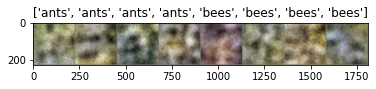

Epoch [30 / 150] average reconstruction error: 468305.968750
Epoch [31 / 150] average reconstruction error: 471277.217500
Epoch [32 / 150] average reconstruction error: 456008.605938
Epoch [33 / 150] average reconstruction error: 455872.963125
Epoch [34 / 150] average reconstruction error: 450029.608125
Epoch [35 / 150] average reconstruction error: 449949.369375
Epoch [36 / 150] average reconstruction error: 450306.716562
Epoch [37 / 150] average reconstruction error: 452963.138750
Epoch [38 / 150] average reconstruction error: 445318.636250
Epoch [39 / 150] average reconstruction error: 441343.439375


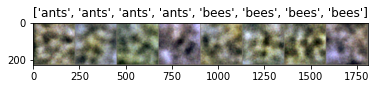

Epoch [40 / 150] average reconstruction error: 435526.056250
Epoch [41 / 150] average reconstruction error: 435048.070625
Epoch [42 / 150] average reconstruction error: 429869.055000
Epoch [43 / 150] average reconstruction error: 425647.297500
Epoch [44 / 150] average reconstruction error: 431213.524375
Epoch [45 / 150] average reconstruction error: 423215.439375
Epoch [46 / 150] average reconstruction error: 420366.332500
Epoch [47 / 150] average reconstruction error: 417379.270937
Epoch [48 / 150] average reconstruction error: 410583.682188
Epoch [49 / 150] average reconstruction error: 420384.117500


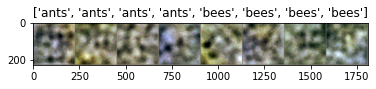

Epoch [50 / 150] average reconstruction error: 413721.547812
Epoch [51 / 150] average reconstruction error: 405147.301563
Epoch [52 / 150] average reconstruction error: 414067.282500
Epoch [53 / 150] average reconstruction error: 403076.733750
Epoch [54 / 150] average reconstruction error: 412858.357500
Epoch [55 / 150] average reconstruction error: 405272.305000
Epoch [56 / 150] average reconstruction error: 407987.583437
Epoch [57 / 150] average reconstruction error: 396321.977500
Epoch [58 / 150] average reconstruction error: 407296.979063
Epoch [59 / 150] average reconstruction error: 404432.385000


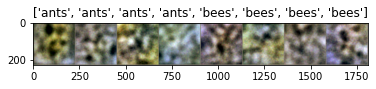

Epoch [60 / 150] average reconstruction error: 407056.840625
Epoch [61 / 150] average reconstruction error: 409757.232500
Epoch [62 / 150] average reconstruction error: 391787.655313
Epoch [63 / 150] average reconstruction error: 386346.378437
Epoch [64 / 150] average reconstruction error: 383413.976250
Epoch [65 / 150] average reconstruction error: 392349.508437
Epoch [66 / 150] average reconstruction error: 389308.092813
Epoch [67 / 150] average reconstruction error: 389365.932500
Epoch [68 / 150] average reconstruction error: 394872.697813
Epoch [69 / 150] average reconstruction error: 393024.349375


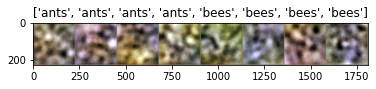

Epoch [70 / 150] average reconstruction error: 391738.585625
Epoch [71 / 150] average reconstruction error: 388674.057812
Epoch [72 / 150] average reconstruction error: 386114.594687
Epoch [73 / 150] average reconstruction error: 384479.704062
Epoch [74 / 150] average reconstruction error: 389453.195937
Epoch [75 / 150] average reconstruction error: 383888.595313
Epoch [76 / 150] average reconstruction error: 380000.898125
Epoch [77 / 150] average reconstruction error: 380922.409375
Epoch [78 / 150] average reconstruction error: 385612.181250
Epoch [79 / 150] average reconstruction error: 380135.043750


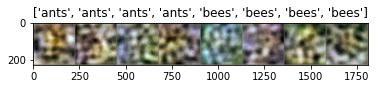

Epoch [80 / 150] average reconstruction error: 377214.560625
Epoch [81 / 150] average reconstruction error: 379331.848125
Epoch [82 / 150] average reconstruction error: 377784.107187
Epoch [83 / 150] average reconstruction error: 381840.438750
Epoch [84 / 150] average reconstruction error: 379987.843438
Epoch [85 / 150] average reconstruction error: 382503.085313
Epoch [86 / 150] average reconstruction error: 380649.060000
Epoch [87 / 150] average reconstruction error: 368213.896562
Epoch [88 / 150] average reconstruction error: 373226.401875
Epoch [89 / 150] average reconstruction error: 369037.412813


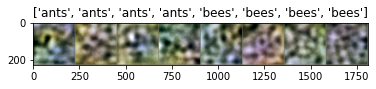

Epoch [90 / 150] average reconstruction error: 381395.558125
Epoch [91 / 150] average reconstruction error: 378242.498125
Epoch [92 / 150] average reconstruction error: 373580.501875
Epoch [93 / 150] average reconstruction error: 366851.867812
Epoch [94 / 150] average reconstruction error: 371246.942188
Epoch [95 / 150] average reconstruction error: 373678.399062
Epoch [96 / 150] average reconstruction error: 371719.976250
Epoch [97 / 150] average reconstruction error: 367227.247812
Epoch [98 / 150] average reconstruction error: 371250.972813
Epoch [99 / 150] average reconstruction error: 378283.608438


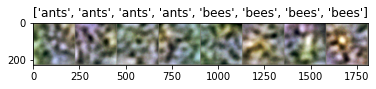

Epoch [100 / 150] average reconstruction error: 369446.940937
Epoch [101 / 150] average reconstruction error: 371846.618125
Epoch [102 / 150] average reconstruction error: 374886.362812
Epoch [103 / 150] average reconstruction error: 369844.147500
Epoch [104 / 150] average reconstruction error: 371401.843750
Epoch [105 / 150] average reconstruction error: 363673.037500
Epoch [106 / 150] average reconstruction error: 365876.191875
Epoch [107 / 150] average reconstruction error: 369764.220313
Epoch [108 / 150] average reconstruction error: 376719.012500
Epoch [109 / 150] average reconstruction error: 374686.497500


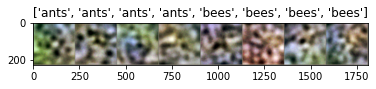

Epoch [110 / 150] average reconstruction error: 371927.133750
Epoch [111 / 150] average reconstruction error: 368706.186250
Epoch [112 / 150] average reconstruction error: 368327.671563
Epoch [113 / 150] average reconstruction error: 366884.511875
Epoch [114 / 150] average reconstruction error: 367974.202813
Epoch [115 / 150] average reconstruction error: 364839.687188
Epoch [116 / 150] average reconstruction error: 372423.631250
Epoch [117 / 150] average reconstruction error: 366186.642813
Epoch [118 / 150] average reconstruction error: 361772.581875
Epoch [119 / 150] average reconstruction error: 369713.062812


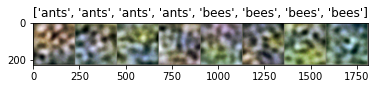

Epoch [120 / 150] average reconstruction error: 372217.860938
Epoch [121 / 150] average reconstruction error: 357723.238438
Epoch [122 / 150] average reconstruction error: 359599.748437
Epoch [123 / 150] average reconstruction error: 367651.727500
Epoch [124 / 150] average reconstruction error: 367371.055937
Epoch [125 / 150] average reconstruction error: 366193.028438
Epoch [126 / 150] average reconstruction error: 361853.572500
Epoch [127 / 150] average reconstruction error: 364001.907813
Epoch [128 / 150] average reconstruction error: 368648.305625
Epoch [129 / 150] average reconstruction error: 367152.636562


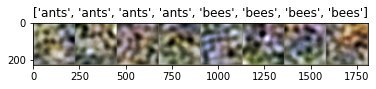

Epoch [130 / 150] average reconstruction error: 363047.791563
Epoch [131 / 150] average reconstruction error: 361328.703125
Epoch [132 / 150] average reconstruction error: 368674.781250
Epoch [133 / 150] average reconstruction error: 364345.890000
Epoch [134 / 150] average reconstruction error: 367369.247812
Epoch [135 / 150] average reconstruction error: 365259.085000
Epoch [136 / 150] average reconstruction error: 362591.461875
Epoch [137 / 150] average reconstruction error: 374480.675000
Epoch [138 / 150] average reconstruction error: 365793.189688
Epoch [139 / 150] average reconstruction error: 364835.427500


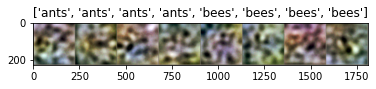

Epoch [140 / 150] average reconstruction error: 366641.718438
Epoch [141 / 150] average reconstruction error: 370176.701875
Epoch [142 / 150] average reconstruction error: 359499.503750
Epoch [143 / 150] average reconstruction error: 365413.025313
Epoch [144 / 150] average reconstruction error: 357789.994063
Epoch [145 / 150] average reconstruction error: 367937.560312
Epoch [146 / 150] average reconstruction error: 368873.916250
Epoch [147 / 150] average reconstruction error: 371387.418438
Epoch [148 / 150] average reconstruction error: 359573.959375
Epoch [149 / 150] average reconstruction error: 368149.755625


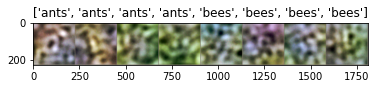

Epoch [150 / 150] average reconstruction error: 360288.022500


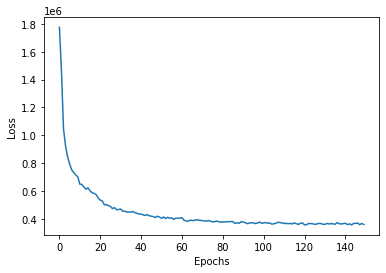

In [24]:
# train the network
# for visualising generation quality during training
def generate(model, num_classes, img_size, num_images=4):
    was_training = model.training
    model.eval()

    with torch.no_grad():
        latent = torch.randn(len(image_datasets['train'].classes) * num_images, latent_dims, device=device)
        classes = torch.zeros(len(image_datasets['train'].classes) * num_images, 1)
        for i in range(len(image_datasets['train'].classes)):
            for j in range(num_images):
                classes[i * num_images + j] = i
        classes = classes.to(device)
        classes = classes.long()
        classes_one_hot = one_hot(classes, num_classes)
        # fetch the generated images by calling the model: 
        images_recon = model.decoder(latent, classes_one_hot)
        images_recon = images_recon.cpu()
        classes = classes.cpu()
        out = torchvision.utils.make_grid(images_recon)

        imshow(out, title=[class_names[x] for x in classes])

    model.train(mode=was_training)

# one-hot channel for conditioning
def one_hot(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return targets.to(device)


# parameters
num_epochs = 150
learning_rate = 1e-4
use_gpu = True
show_images_every = 10
num_classes = len(class_names)
for image_batch, class_batch in dataloader:
    img_size = image_batch.size(2)
    break


vae = VariationalAutoencoder(num_classes, img_size)

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)

optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
vae.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    # use mini batches from dataloader
    for image_batch, class_batch in dataloader:
        # print(torch.min(image_batch), torch.max(image_batch))
        
        image_batch, class_batch = image_batch.to(device), class_batch.to(device)
        class_batch = one_hot(class_batch, num_classes)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch, class_batch, img_size)
        
        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
    
    if (epoch+1) % show_images_every == 0:
        generate(vae, num_classes, img_size, 4)
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))


# show how loss evolves during training
plt.ion()
fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

g) Does this model work well enough? What might be the reason for this? 

It does not work too well. The dataset is too small for the model to learn good features for the latent space distribution.